## BASE SENSITIVITY ANALYSIS

In [1]:
import dolfin as dolf
from math import pi, sqrt
import matplotlib.pyplot as plt
import numpy as np

from helmholtz_pkg.passive_flame import PassiveFlame
from helmholtz_pkg.flame_transfer_function import n_tau
from helmholtz_pkg.active_flame import ActiveFlame
from helmholtz_pkg.eigensolvers import fixed_point_iteration_pep, pep_solver
from helmholtz_pkg.eigenvectors import normalize_eigenvector
from helmholtz_pkg.petsc4py_utils import vector_matrix_vector, vector_vector
import params

In [2]:
plt.rcParams['figure.figsize'] = [11, 4]

In [3]:
def mshr(el):

    mesh = dolf.UnitIntervalMesh(el)

    def l_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 0.)

    def r_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 1.)

    boundaries = dolf.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)

    l_boundary = dolf.AutoSubDomain(l_boundary_func)
    r_boundary = dolf.AutoSubDomain(r_boundary_func)

    l_boundary.mark(boundaries, 1)
    r_boundary.mark(boundaries, 2)

    # ________________________________________________________________________________

    def fl_subdomain_func(x):
        x = x[0]
        x_f = params.x_f[0][0]
        a_f = params.a_f
        return x_f - a_f - dolf.DOLFIN_EPS <= x <= x_f + a_f + dolf.DOLFIN_EPS

    subdomains = dolf.MeshFunction('size_t', mesh, mesh.topology().dim())

    subdomains.set_all(1)

    fl_subdomain = dolf.AutoSubDomain(fl_subdomain_func)
    fl_subdomain.mark(subdomains, 0)

    return mesh, boundaries, subdomains

In [4]:
degree = 1

mesh, boundaries, subdomains = mshr(400)

boundary_conditions = {1: {'Robin': params.Y_in},  # inlet
                        2: {'Robin': params.Y_out}}  # outlet

foo = PassiveFlame(mesh, boundaries, boundary_conditions,
                    c=params.c_,
                    degree=degree)
foo.assemble_A()
foo.assemble_B()
foo.assemble_C()

E = pep_solver(foo.A, foo.B, foo.C, pi, nev=2)

omega_dir, p_dir = normalize_eigenvector(mesh, E, i=1, degree=degree, which='right')
omega_adj, p_adj = normalize_eigenvector(mesh, E, i=1, degree=degree, which='left')
print(omega_dir, omega_adj)

p_dir_r, p_dir_i = p_dir.split()
p_adj_r, p_adj_i = p_adj.split()

Normalization relation is | p p dx = 1 
Normalization relation is | p p dx = 1 
(3.429768679672394-0.027128141633017362j) (3.429768679672394-0.027128141633017362j)


In [5]:
# BASE STATE SENSITIVITY ------------------------------------------------------------------------------------------

p_dir_vec = p_dir.vector().vec()
p_adj_vec = p_adj.vector().vec()

dLds = foo.B + foo.assemble_zC(2 * omega_dir)

denominator = -vector_matrix_vector(p_adj_vec , dLds , p_dir_vec )
print(denominator)

(-6.746507245108422+0.0009004262315202571j)


In [6]:
W = foo.function_space
dx = dolf.Measure('dx', domain = mesh)
# MATRIX dA
(u_1, u_2) = foo.u
(v_1, v_2) = foo.v

da_11 = -2 * params.c_ * dolf.dot(dolf.grad(v_1), dolf.grad(u_1)) * dx
da_22 = -2 * params.c_ * dolf.dot(dolf.grad(v_2), dolf.grad(u_2)) * dx
da_ = da_11 + da_22


In [7]:
dofmap = W.dofmap()
ds_dc = np.zeros(mesh.num_vertices()-1,dtype=complex)

for i, cell in enumerate(dolf.cells(mesh)):
    # Assemble locally the derivative dLdc for the corresponding cell
    dLdc = dolf.assemble_local(da_ , cell)
    # Finding the dof's indices in the current cell
    indices = dofmap.cell_dofs(cell.index())
    # Calculating left and right eigenvectors for current cell by using indices
    p_left = p_adj.vector()[indices]
    p_right = p_dir.vector()[indices]
    #print(indices, p_left, p_right)
    
    # Determine nominator = p_left * dLdc * p_right
    nominator = np.matmul(np.transpose(p_left), (np.matmul(dLdc , p_right)))
    # Append the result to the numpy array
    ds_dc[i] = nominator / denominator



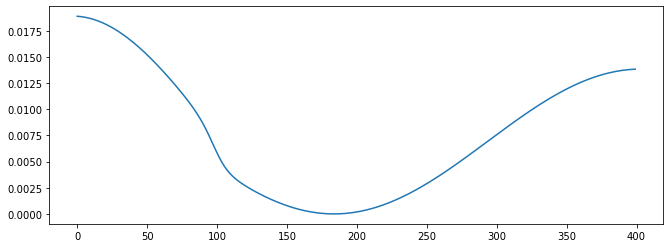

In [8]:
plt.plot(abs(ds_dc))

In [9]:
dofmap = foo.function_space.dofmap()
ds_dc = np.zeros(mesh.num_vertices()-1,dtype=complex)
dL_dc = []
for i, cell in enumerate(dolf.cells(mesh)):
    # Assemble locally the derivative dLdc for the corresponding cell
    dLdc = dolf.assemble_local(da_ , cell)
    dL_dc.append(dLdc)
    # Finding the dof's indices in the current cell
    indices = dofmap.cell_dofs(cell.index())
    # Calculating left and right eigenvectors for current cell by using indices
    p_left = p_adj.vector()[indices]
    p_right = p_dir.vector()[indices]
    def real_to_complex(p):
        p_r = np.array(p[0:int(len(p)/2)])
        p_i = 1j*np.array(p[int(len(p)/2):])
        p_c = p_r + p_i
        return p_c
    p_left = real_to_complex(p_left)
    p_right = real_to_complex(p_right)
    # Determine nominator = p_left * dLdc * p_right
    dLdc = dLdc[0:2,0:2]
    nominator = np.dot(np.transpose(p_left), (np.dot(dLdc , p_right)))
    # Append the result to the numpy array
    ds_dc[i] = nominator / denominator
print(ds_dc[78:81])


[0.01100522-0.00039727j 0.01083194-0.0003919j  0.01065562-0.00038637j]


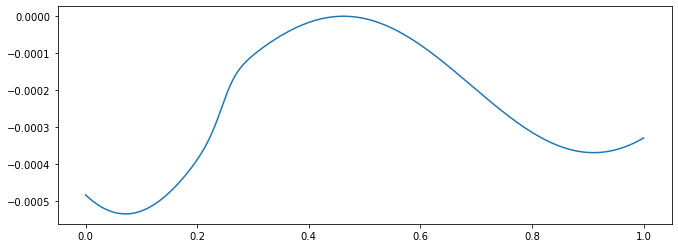

In [10]:
plt.plot(np.linspace(0,1,400),ds_dc.imag)